In [2]:
librarian::shelf(tidyverse, tidymodels, DataExplorer, GGally, corrplot, plotly, viridis,
pROC, factoextra, cluster, ggthemes, ggridges, scales, vcd, kableExtra, DT, 
MASS, Rtsne, tsne, umap, conflicted, caTools, gridExtra,scales, entropy, RColorBrewer,
igraph, ggraph, qgraph, PCAtest)

In [3]:
# Set custom theme

theme_custom <- function() {
  theme_minimal() +
    theme(
      plot.background = element_rect(fill = "white", color = NA),
      panel.grid.major = element_line(color = "gray90"),
      panel.grid.minor = element_blank(),
      plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
      plot.subtitle = element_text(size = 12, color = "gray30", hjust = 0.5),
      axis.title = element_text(size = 12, face = "bold"),
      axis.text = element_text(size = 10),
      legend.title = element_text(size = 12, face = "bold"),
      legend.text = element_text(size = 10),
      legend.position = "right"
    )
}

theme_set(theme_custom())



# 1. Introduction

This document presents an intensive exploratory loan_data analysis (EDA) and statistical analysis of a loan status loan_dataset. The goal is to uncover patterns, relationships, and insights that can help predict loan statuss. The analysis includes:

- loan_data preprocessing and cleaning
- Univariate analysis with advanced visualizations
- Bivariate and multivariate analysis
- Correlation analysis with sophisticated visualizations
- Feature importance and selection
- Statistical modeling and predictive analysis
- Advanced dimensionality reduction and visualization techniques

Let's begin by loading and examining the loan_dataset.

# 2. loan_data Loading and Initial Exploration

In [4]:
conflicted::conflicts_prefer(dplyr::select)
tidymodels_prefer()

[conflicted] Will prefer dplyr::select over any other package.


In [5]:
loan_data <- read_csv("dataset/Loan_Default.csv")

Rows: 148670 Columns: 34
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (21): loan_limit, Gender, approv_in_adv, loan_type, loan_purpose, Credit_Worthiness, open_credit, business_or_commercial, Neg_ammortization, i...
dbl (13): ID, year, loan_amount, rate_of_interest, Interest_rate_spread, Upfront_charges, term, property_value, income, Credit_Score, LTV, Status,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
loan_data %>% 
  janitor::clean_names() %>%
  select(-id) -> loan_data


In [7]:
# Select 20000 observations while maintaining the distribution in the target variable
# for fast modelling and visualization before upscaling
set.seed(42)

split_ratio <- 20000 / nrow(loan_data)
split_index <- sample.split(loan_data$status, SplitRatio = split_ratio)

# Extract the sample
data <- loan_data[split_index, ]

In [8]:
# Verify if the distribution is maintained
print(table(loan_data$status) / nrow(loan_data))
print(table(data$status) / nrow(data))


        0         1 
0.7535549 0.2464451 

      0       1 
0.75355 0.24645 


In [9]:
cat("Dimensions of the loan_dataset", dim(data)[1], "rows and ", dim(data)[2], " columns")

Dimensions of the loan_dataset 20000 rows and  33  columns

In [10]:
head(data)

# A tibble: 6 × 33
   year loan_limit gender       approv_in_adv loan_type loan_purpose credit_worthiness open_credit business_or_commercial loan_amount rate_of_interest
  <dbl> <chr>      <chr>        <chr>         <chr>     <chr>        <chr>             <chr>       <chr>                        <dbl>            <dbl>
1  2019 cf         Joint        pre           type1     p1           l1                nopc        nob/c                       696500             4   
2  2019 cf         Joint        pre           type1     p3           l1                nopc        nob/c                       346500             4.5 
3  2019 cf         Sex Not Ava… nopre         type1     p3           l1                nopc        nob/c                       466500             4.38
4  2019 cf         Female       nopre         type1     p1           l1                nopc        nob/c                       186500             4.25
5  2019 cf         Female       nopre         type1     p1           l1    

In [11]:
skimr::skim(data) %>% 
  as_tibble() %>% 
  kable(caption = "Summary Statistics of the loan loan_data")



Table: Summary Statistics of the loan loan_data

|skim_type |skim_variable             | n_missing| complete_rate| character.min| character.max| character.empty| character.n_unique| character.whitespace| numeric.mean|   numeric.sd|   numeric.p0|  numeric.p25|  numeric.p50|  numeric.p75| numeric.p100|numeric.hist |
|:---------|:-------------------------|---------:|-------------:|-------------:|-------------:|---------------:|------------------:|--------------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|:------------|
|character |loan_limit                |       483|       0.97585|             2|             3|               0|                  2|                    0|           NA|           NA|           NA|           NA|           NA|           NA|           NA|NA           |
|character |gender                    |         0|       1.00000|             4|            17|               0|                  4|                

In [12]:
# Convert all character loan_amounts to factors

data <- data %>% mutate_if(is.character, as.factor)

## Missing loan_data Analysis


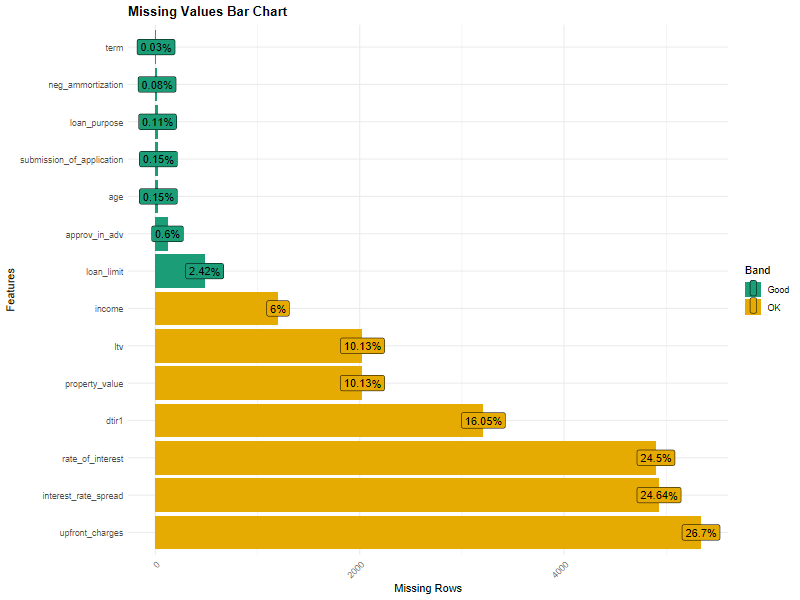

In [13]:
plot_missing(data, missing_only = TRUE, title = "Missing Values Bar Chart") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        plot.title = element_text(face = "bold"))

In [14]:
#Convert all character variables to factors
data <- data %>% 
  mutate_if(is.character, as.factor)

head(data)

# A tibble: 6 × 33
   year loan_limit gender       approv_in_adv loan_type loan_purpose credit_worthiness open_credit business_or_commercial loan_amount rate_of_interest
  <dbl> <fct>      <fct>        <fct>         <fct>     <fct>        <fct>             <fct>       <fct>                        <dbl>            <dbl>
1  2019 cf         Joint        pre           type1     p1           l1                nopc        nob/c                       696500             4   
2  2019 cf         Joint        pre           type1     p3           l1                nopc        nob/c                       346500             4.5 
3  2019 cf         Sex Not Ava… nopre         type1     p3           l1                nopc        nob/c                       466500             4.38
4  2019 cf         Female       nopre         type1     p1           l1                nopc        nob/c                       186500             4.25
5  2019 cf         Female       nopre         type1     p1           l1    

In [15]:
# Remove Zero Variance columns and then perform knn imputation
data <- recipe(status ~ ., data) %>% 
  step_zv(all_predictors()) %>% 
  step_impute_knn(all_predictors()) %>% 
  prep() %>% 
  bake(new_data = NULL)

In [16]:
colSums(is.na(data))

               loan_limit                    gender             approv_in_adv                 loan_type              loan_purpose 
                        0                         0                         0                         0                         0 
        credit_worthiness               open_credit    business_or_commercial               loan_amount          rate_of_interest 
                        0                         0                         0                         0                         0 
     interest_rate_spread           upfront_charges                      term         neg_ammortization             interest_only 
                        0                         0                         0                         0                         0 
         lump_sum_payment            property_value         construction_type            occupancy_type                secured_by 
                        0                         0                         0      

# 3. Univariate Analysis

## 3.1 Distribution of Numeric loan_amounts

In [17]:
data$status <- factor(data$status, 
  levels = c(0, 1), 
  labels = c("No", "Yes"))

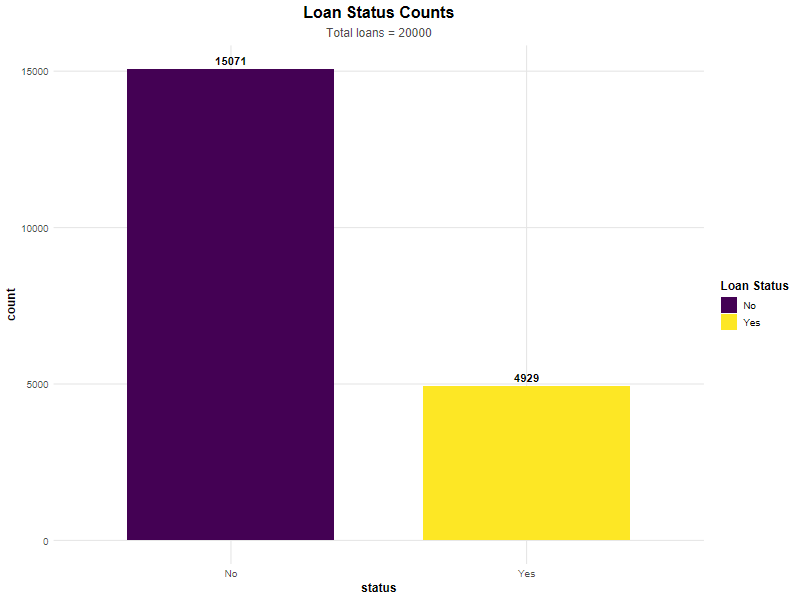

In [18]:
status_counts <- data %>% 
  count(status) %>% 
  mutate(percentage = n / sum(n) * 100)

ggplot(data, aes(status, fill = status)) +
  geom_bar(width = 0.7) +
  geom_text(stat = "count", 
             aes(label = after_stat(count)),
             vjust = -0.5,
             size = 4, fontface = "bold") +
  scale_fill_viridis_d(option = "D") +
  labs(title = "Loan Status Counts",
      subtitle = paste("Total loans =", nrow(data)),
      fill = "Loan Status") +
  theme_custom() -> p1

p1

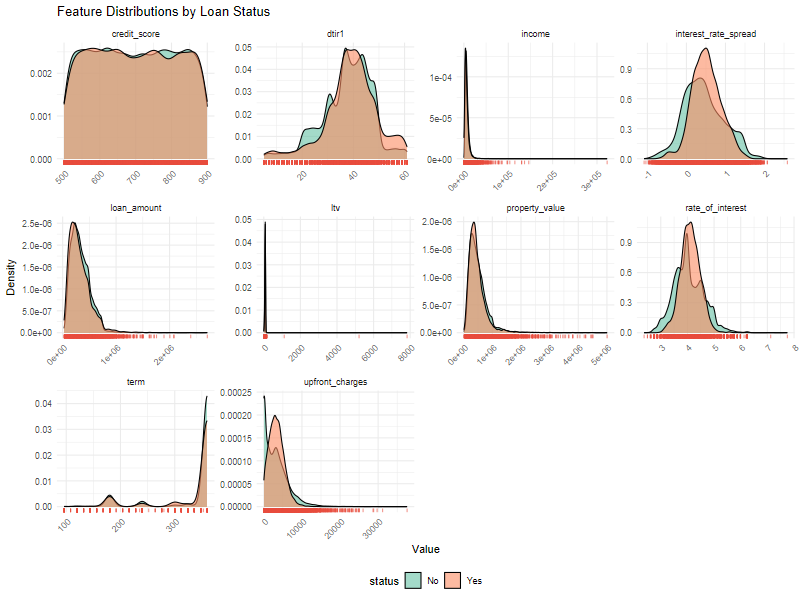

In [19]:
numeric_cols <- data %>% 
  select_if(is.numeric) %>% 
  names()

numeric_data <- data %>% 
  select(any_of(c(numeric_cols, "status"))) %>% 
  pivot_longer(cols = -status, names_to = "features", values_to = "values")

p2 <- ggplot(numeric_data, aes(values, fill = status)) +
  geom_density(alpha = 0.6) +
  geom_rug(alpha = 0.6, color = "#e74c3c") +
  facet_wrap(~features, scales = "free") +
  labs(title = "Feature Distributions by Loan Status",
  x = "Value", y = "Density") +
  scale_fill_manual(values = c("No" = "#66c2a5", 
  "Yes" = "#fc8d62")) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
     legend.position = "bottom")

p2
  

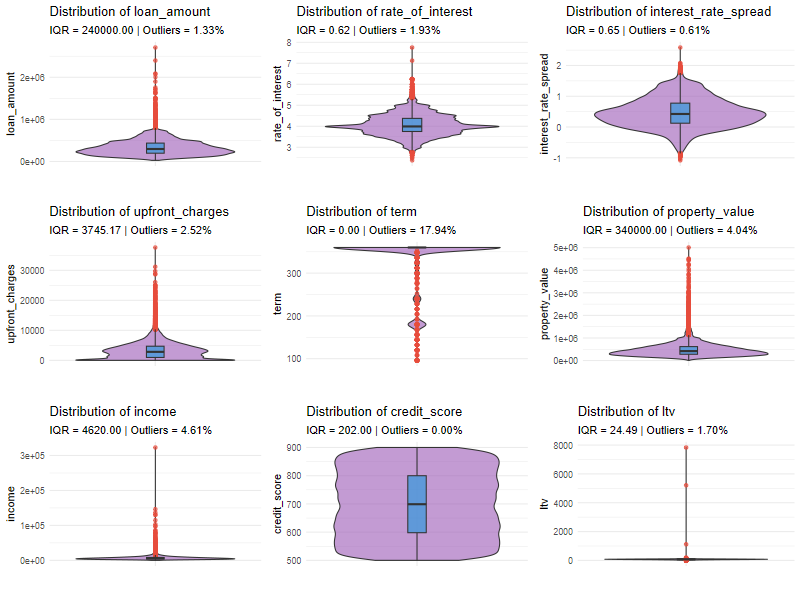

In [20]:
# Function to plot boxplots with violin overlay
plot_box <- function(data, variable) {
  q <- quantile(data[[variable]], probs = c(0.25, 0.75), na.rm = TRUE)
  iqr <- diff(q)
  bounds <- q + c(-1.5, 1.5) * iqr
  outlier_pct <- mean(data[[variable]] < bounds[1] | data[[variable]] > bounds[2], na.rm = TRUE) * 100
  
  ggplot(data, aes(y = .data[[variable]], x = "")) +
    geom_violin(fill = "#9b59b6", alpha = 0.6) +
    geom_boxplot(width = 0.1, fill = "#3498db", alpha = 0.7, outlier.color = "#e74c3c") +
    labs(
      title = paste("Distribution of", variable),
      subtitle = sprintf("IQR = %.2f | Outliers = %.2f%%", iqr, outlier_pct),
      y = variable, x = ""
    ) +
    theme_minimal()
}

# Generate and arrange plots for first 9 numeric features
plots <- lapply(head(numeric_cols, 9), plot_box, data = data)
grid.arrange(grobs = plots, ncol = 3)


## Distribution of categorical features

In [21]:
categorical_cols <- data %>% 
  select(where(~ !is.numeric(.))) %>% 
  names()

categorical_cols

 [1] "loan_limit"                "gender"                    "approv_in_adv"             "loan_type"                 "loan_purpose"             
 [6] "credit_worthiness"         "open_credit"               "business_or_commercial"    "neg_ammortization"         "interest_only"            
[11] "lump_sum_payment"          "construction_type"         "occupancy_type"            "secured_by"                "total_units"              
[16] "credit_type"               "co_applicant_credit_type"  "age"                       "submission_of_application" "region"                   
[21] "security_type"             "status"                   

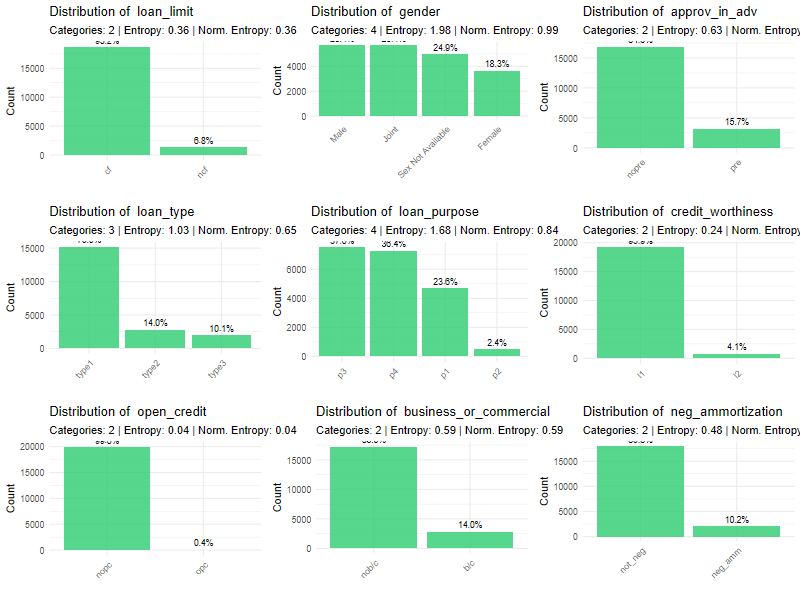

In [22]:
 
options(repr.plot.height = 24, repr.plot.width = 24)

if (length(categorical_cols) > 0) {
  
  
  plot_bar <- function(data, variable) {
    freq_table <- table(data[[variable]])
    freq_df <- as.data.frame(freq_table) %>%
      rename(Category = Var1, Count = Freq) %>%
      mutate(Percentage = Count / sum(Count) * 100) %>%
      arrange(desc(Count))
    
    # Compute Shannon's entropy
    entropy_value <- entropy(freq_df$Count, unit = "log2")
    norm_entropy <- entropy_value / log2(nrow(freq_df))
    
    # Plot
    ggplot(freq_df, aes(reorder(Category, -Count), Count)) +
      geom_bar(stat = "identity", fill = "#2ecc71", alpha = 0.8) +
      geom_text(aes(label = sprintf("%.1f%%", Percentage)), 
                vjust = -0.5, color = "black", size = 3) +
      labs(
        title = paste("Distribution of ", variable),
        subtitle = sprintf("Categories: %d | Entropy: %.2f | Norm. Entropy: %.2f", 
                           nrow(freq_df), entropy_value, norm_entropy),
        x = "", y = "Count"
      ) +
      theme_minimal() +
      theme(axis.text.x = element_text(angle = 45, hjust = 1))
  }
  
  # Auto-adjust grid layout
  num_plots <- min(9, length(categorical_cols))  # Max 9 plots
  num_cols <- ceiling(sqrt(num_plots))  # Dynamic columns
  num_rows <- ceiling(num_plots / num_cols)  # Dynamic rows
  
  # Generate plots
  plot_list <- lapply(head(categorical_cols, num_plots), function(col) plot_bar(data, col))
  grid::grid.newpage()
  do.call(grid.arrange, c(plot_list, ncol = num_cols, nrow = num_rows))
}


# 4. Bivariate Analysis

## 4.1 Relationship Between Target Variable and Numeric Predictors

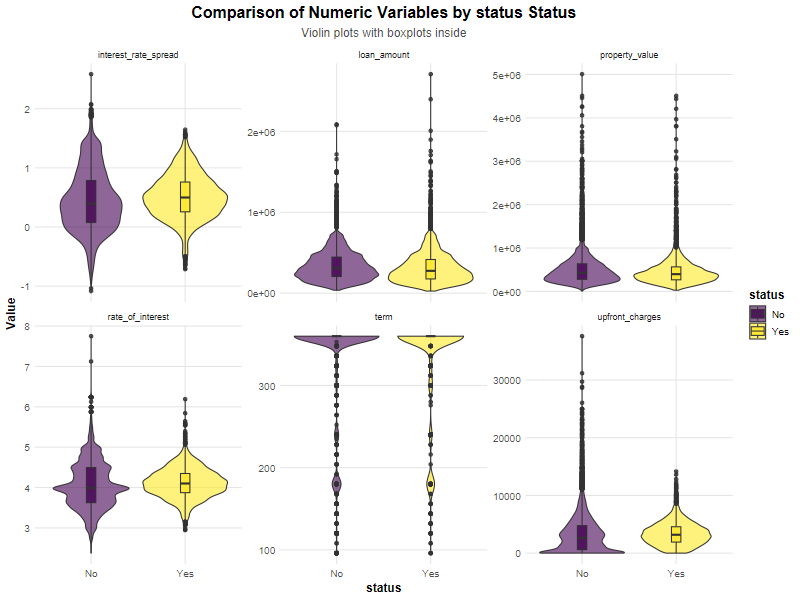

In [23]:
target_var <- "status"
violin_plot_data <- data %>%
    select(all_of(c(target_var, numeric_cols[1:min(6, length(numeric_cols))]))) %>%
    pivot_longer(cols = -all_of(target_var), names_to = "Variable", values_to = "Value")

  
ggplot(violin_plot_data, aes(x = .data[[target_var]], y = Value, fill = .data[[target_var]])) +
  geom_violin(alpha = 0.6) +
  geom_boxplot(width = 0.1, alpha = 0.8) +
  scale_fill_viridis_d() +
  facet_wrap(~ Variable, scales = "free_y", ncol = 3) +
  labs(
    title = "Comparison of Numeric Variables by status Status",
    subtitle = "Violin plots with boxplots inside",
    x = target_var,
    y = "Value"
  ) +
  theme_custom()

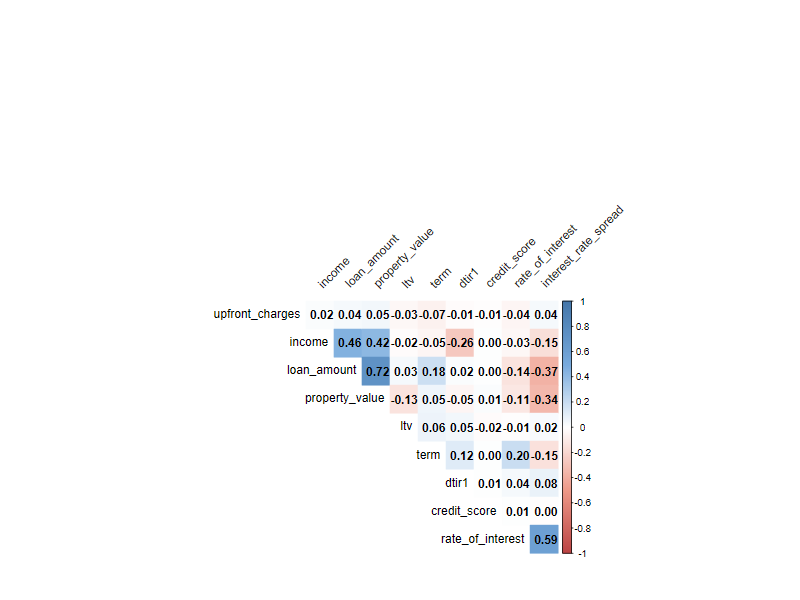

In [24]:
options(repr.plot.height = 14, repr.plot.width = 14)
cor_matrix <- cor(data[, numeric_cols], use = "pairwise.complete.obs")
col <- colorRampPalette(c("#BB4444", "#EE9988", "#FFFFFF", "#77AADD", "#4477AA"))
corrplot(cor_matrix, method="color", col=col(200),  
         type="upper", order="hclust", 
         addCoef.col = "black", # Add coefficient of correlation
         tl.col="black", tl.srt=45, #Text label color and rotation
         # Combine with significance
        sig.level = 0.01, insig = "blank", 
         # hide correlation coefficient on the principal diagonal
         diag=FALSE 
         )

### Network plot of correlations

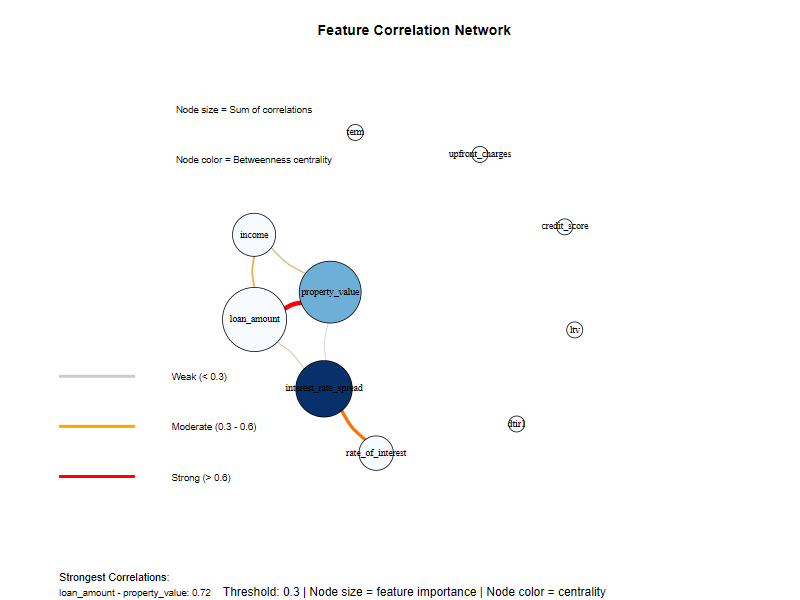

In [34]:

# Set threshold for "high correlation"
threshold <- 0.3
# Define correlation strength labels and corresponding colors
legend_labels <- c("Weak (< 0.3)", "Moderate (0.3 - 0.6)", "Strong (> 0.6)")
correlation_colors <- c("#CCCCCC", "#FFA500", "#FF0000")  
 


# Apply threshold to correlation matrix
cor_filtered <- cor_matrix
cor_filtered[abs(cor_filtered) < threshold] <- 0  # Filter weak correlations
diag(cor_filtered) <- 0  # Remove self-correlations

# Ensure no missing values
cor_filtered[is.na(cor_filtered)] <- 0

# Create network graph from adjacency matrix
net <- graph_from_adjacency_matrix(
  abs(cor_filtered),
  mode = "undirected",
  weighted = TRUE,
  diag = FALSE
)

# Calculate node metrics
btw <- betweenness(net, normalized = TRUE)
strength <- strength(net)

# Set vertex attributes
V(net)$size <- 10 + 30 * rescale(strength)  # Normalize sizes
V(net)$color <- colorRampPalette(brewer.pal(9, "Blues"))(100)[cut(rescale(btw), breaks = 100, labels = FALSE)]

# Set edge attributes
E(net)$width <- 1 + 5 * rescale(E(net)$weight)
E(net)$color <- colorRampPalette(c("#CCCCCC", "#FFA500", "#FF0000"))(100)[cut(rescale(E(net)$weight), breaks = 100, labels = FALSE)]

# Create layout
set.seed(42)
graph_layout <- layout_with_fr(net)

# Plot network
plot(net,
     layout = graph_layout,
     main = "Feature Correlation Network",
     sub = paste("Threshold:", threshold, "| Node size = feature importance | Node color = centrality"),
     vertex.label.color = "black",
     vertex.label.cex = 0.8,
     edge.curved = 0.2,
     edge.arrow.size = 0,
     margin = c(0.15, 0.15, 0.15, 0.15)
)

# Move the correlation strength legend slightly left
legend("bottomleft",
       legend = legend_labels,
       col = correlation_colors,
       lwd = 4,
       bty = "n",
       cex = 0.8,
       inset = c(-0.1, 0) # Move it slightly outside the plot
)


# Move the node properties legend slightly outside the plot
legend("topright",
       legend = c("Node size = Sum of correlations", 
                  "Node color = Betweenness centrality"),
       bty = "n",
       cex = 0.8,
       inset = c(-0.2, 0), # Move it slightly outside
       xpd = TRUE 
)


# Add top correlations
if (ecount(net) > 0) {
  top_edges <- head(E(net)[order(E(net)$weight, decreasing = TRUE)], 5)
  if (length(top_edges) > 0) {
    mtext("Strongest Correlations:", side = 1, line = 3, adj = 0, cex = 0.9)
    for (i in 1:length(top_edges)) {
      edge <- top_edges[i]
      edge_ends <- ends(net, edge)
      v1 <- V(net)[edge_ends[1]]$name
      v2 <- V(net)[edge_ends[2]]$name
      weight <- round(E(net)[edge]$weight, 2)
      mtext(paste0(v1, " - ", v2, ": ", weight), side = 1, line = 3 + i, adj = 0, cex = 0.8)
    }
  }
}


Community membership:
Community 1 : loan_amount property_value income 
Community 2 : rate_of_interest interest_rate_spread 
Community 3 : upfront_charges 
Community 4 : term 
Community 5 : credit_score 
Community 6 : ltv 
Community 7 : dtir1 


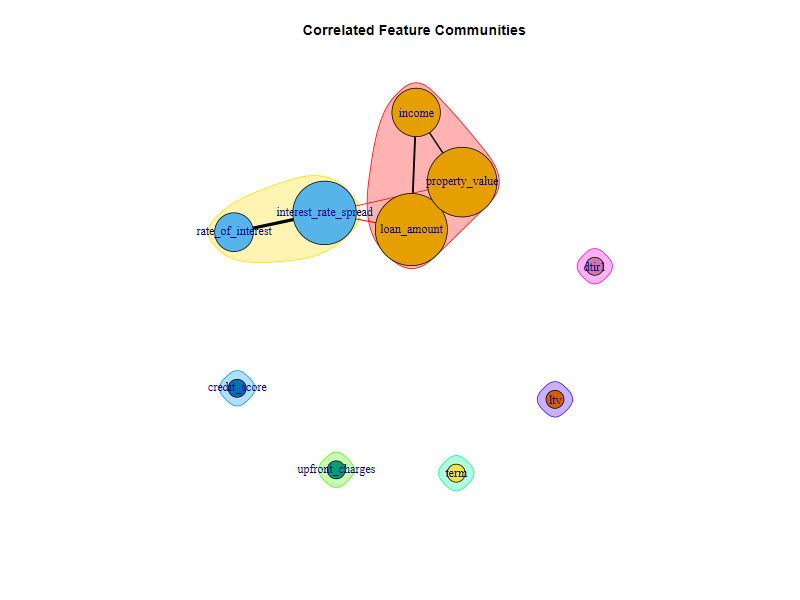

In [35]:
# Detect communities in the network
comm <- cluster_louvain(net)

plot(comm, net, 
     layout = layout_with_fr(net),
     main = "Correlated Feature Communities")

cat("Community membership:\n")
for (i in 1:max(membership(comm))) {
  cat("Community", i, ":", names(membership(comm))[membership(comm) == i], "\n")
}


# 5. Multivariate Analysis

## 5.1 Advanced Scatter Plot Matrix

# Select a subset of the most interesting numeric variables

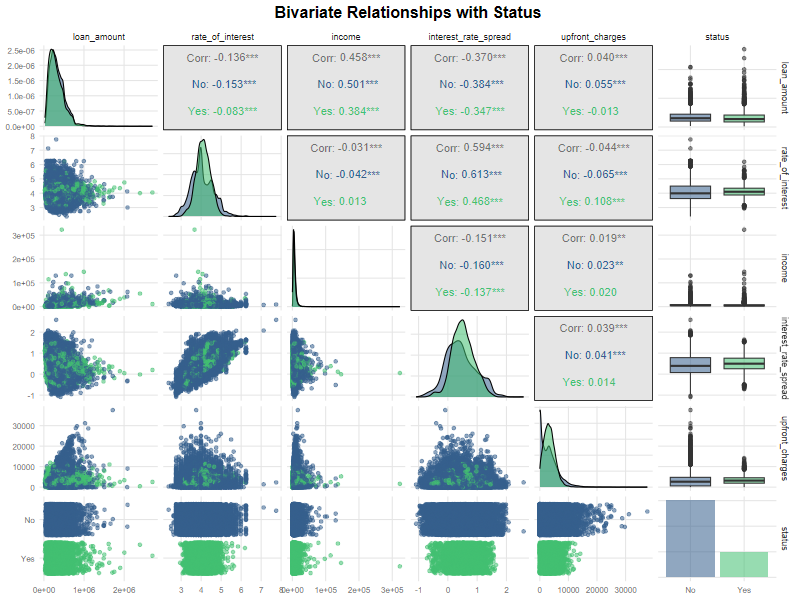

In [36]:
# Select a few key variables for bivariate analysis
key_vars <- c("loan_amount", "rate_of_interest", "income","interest_rate_spread", "upfront_charges", "status")

data %>%
  select(all_of(key_vars)) %>%
  ggpairs(aes(color = status, alpha = 0.5),
          upper = list(continuous = "cor", combo = "box_no_facet"),
          lower = list(continuous = "points", combo = "dot_no_facet"),
          diag = list(continuous = "densityDiag"),
          progress = FALSE) +
  scale_color_viridis_d(option = "D", begin = 0.3, end = 0.7) +
  scale_fill_viridis_d(option = "D", begin = 0.3, end = 0.7) +
  labs(title = "Bivariate Relationships with Status") +
  theme(axis.text = element_text(size = 8),
        strip.text = element_text(size = 9))

## 5.2 Dimensionality Reduction and Visualization
### Sparse PCA

Sparse PCA aims to find principal components that explain the maximum variance while having as few non-zero loadings as possible. This helps identify the most important features (genes, clinical markers, etc.) that characterize different cancer subtypes.

In [37]:
num_data <- data %>% 
  select(any_of(numeric_cols))

# Examine the dataset structure
dim_desc <- paste("Dataset dimensions:", paste(dim(num_data), collapse = "x"))
feature_desc <- paste("First few feature names:", 
                      paste(colnames(num_data)[1:5], collapse=", "), "...")
cat(dim_desc, "\n", feature_desc)

## Center and scale the data

loan_scaled <- scale(num_data)


Dataset dimensions: 20000x10 
 First few feature names: loan_amount, rate_of_interest, interest_rate_spread, upfront_charges, term ...


---------------------
Welcome to dendextend version 1.19.0
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
You may ask questions at stackoverflow, use the r and dendextend tags: 
	 https://stackoverflow.com/questions/tagged/dendextend

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------



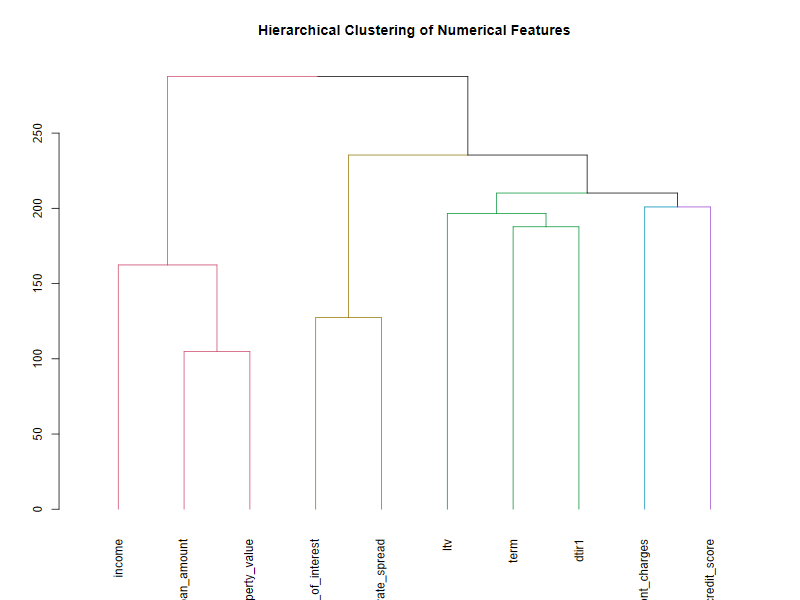

In [38]:
library(dendextend)
# Hierarchical clustering of features
feature_dist <- dist(t(loan_scaled))
feature_hclust <- hclust(feature_dist, method = "ward.D2")
feature_dend <- as.dendrogram(feature_hclust)
feature_dend <- color_branches(feature_dend, k = 5)

# Create clustering visualization
plot(feature_dend, main = "Hierarchical Clustering of Numerical Features",
     xlab = "", sub = "")

You may wish to restart and use a more efficient way 
let the argument x be the sample covariance/correlation matrix and set type=Gram 


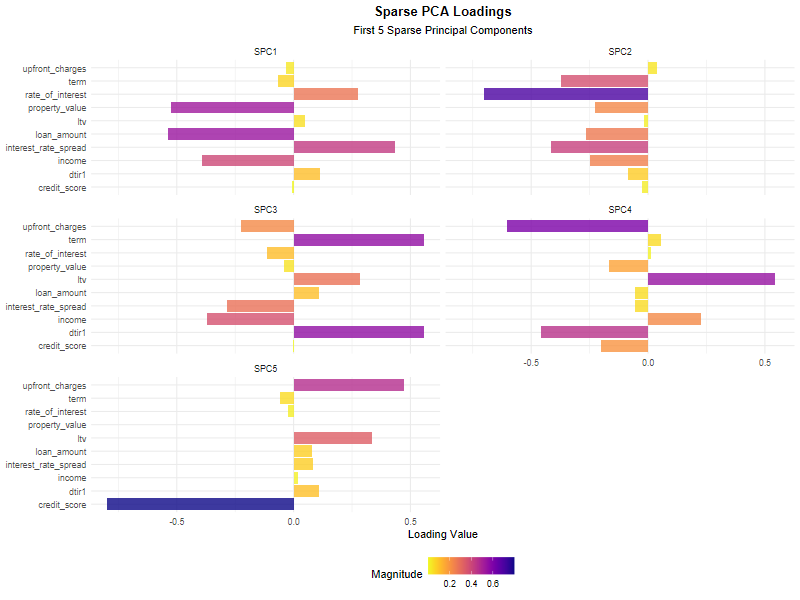

In [64]:
library(elasticnet)
library(rospca)
library(PMA)
loan_cov <- cov(loan_scaled)
sparse_pca <- spca(loan_scaled,
                  K = 5, # Number of components
                  para = c(rep(0.4, 5)), # Sparsity parameters for each component
                  type = "predictor",
                  sparse = "penalty" # How do I induce sparsity?
                )

loadings_sparse <- sparse_pca$loadings
# Prepare the data for visualization
loadings_sparse_df <- as.data.frame(loadings_sparse)
colnames(loadings_sparse_df) <- paste0("SPC", 1:ncol(loadings_sparse_df))
loadings_sparse_df$Variable <- rownames(loadings_sparse_df)
loadings_sparse_long <- pivot_longer(loadings_sparse_df,
                                    cols = starts_with("SPC"),
                                    names_to = "Component",
                                    values_to = "Loading")
# Visualize the Sparse PCA Loadings
ggplot(loadings_sparse_long, aes(Variable, Loading, fill = abs(Loading))) +
  geom_bar(stat = "identity", alpha = 0.8) +
  facet_wrap(~ Component, ncol = 2) +
  coord_flip() +
  scale_fill_viridis(option = "plasma", direction = -1) +
  labs(title = "Sparse PCA Loadings",
  subtitle = "First 5 Sparse Principal Components",
  x = NULL,
  y = "Loading Value",
  fill = "Magnitude") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),
   plot.subtitle = element_text(hjust = 0.5),
   legend.position = "bottom")

## Tuning the Sparsity Parameter

The sparsity parameter controls the trade-off between variance explained and interpretability. Let's examine how different lambda values affect sparsity:

In [54]:
# Try different sparsity parameters
sparsity_levels <- seq(0.1, 0.9, 0.1)
spca_results <- list()

for (i in seq_along(sparsity_levels)) {
  spca_results[[i]] <- spca(loan_cov, K = 5, 
                           para = rep(sparsity_levels[i], 5),
                           type = "Gram", sparse = "penalty")
}

# Select optimal sparsity based on variance explained vs sparsity tradeoff
sparsity_metrics <- data.frame(
  sparsity = sparsity_levels,
  nonzero_loadings = sapply(spca_results, function(x) mean(colSums(x$loadings != 0))),
  stringsAsFactors = FALSE
)

# Function to estimate variance explained for SPCA
calc_spca_var <- function(X, loadings) {
  scores <- X %*% loadings
  explained_var <- apply(scores, 2, var)
  total_var <- sum(apply(X, 2, var))
  return(explained_var / total_var * 100)
}

# Calculate variance explained for each sparsity level
for (i in seq_along(sparsity_levels)) {
  sparsity_metrics$var_explained_pc1_5[i] <- 
    sum(calc_spca_var(loan_scaled, spca_results[[i]]$loadings)[1:5])
}

# Choose optimal sparsity level (example criterion)
best_idx <- which.max(sparsity_metrics$var_explained_pc1_5 / sparsity_metrics$nonzero_loadings)
optimal_sparsity <- sparsity_levels[best_idx]

# Display sparsity comparison
knitr::kable(sparsity_metrics, digits = 2, 
             caption = paste("Sparsity-Variance Tradeoff (Optimal: ", optimal_sparsity, ")"))



Table: Sparsity-Variance Tradeoff (Optimal:  0.4 )

| sparsity| nonzero_loadings| var_explained_pc1_5|
|--------:|----------------:|-------------------:|
|      0.1|              2.4|               69.50|
|      0.2|              2.2|               68.62|
|      0.3|              1.8|               67.82|
|      0.4|              1.6|               66.69|
|      0.5|              1.6|               65.85|
|      0.6|              1.6|               65.39|
|      0.7|              1.6|               64.69|
|      0.8|              1.6|               63.60|
|      0.9|              1.6|               61.86|

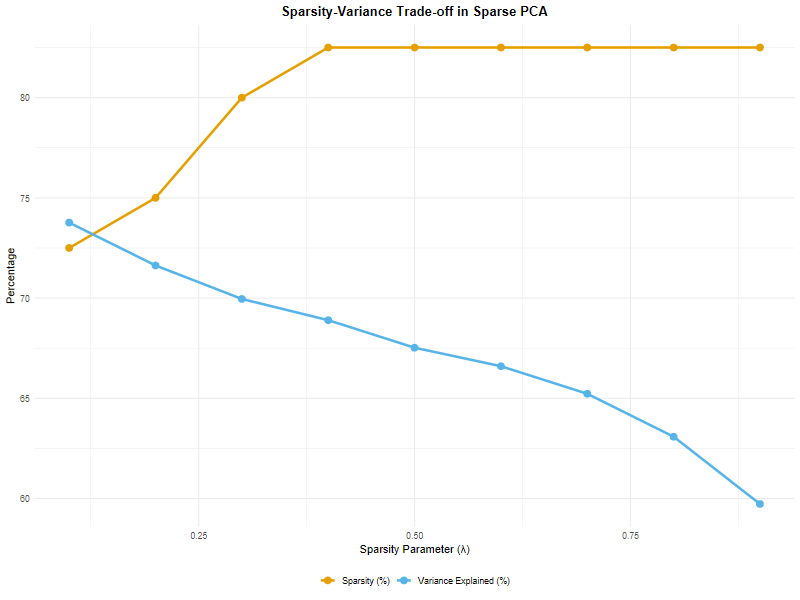

In [55]:
# Function to calculate sparsity (% of zero loadings)
calculate_sparsity <- function(loadings_matrix) {
  total_elements <- prod(dim(loadings_matrix))
  zero_elements <- sum(loadings_matrix == 0)
  return(zero_elements / total_elements * 100)
}

# Test different sparsity parameters
lambda_values <- seq(0.1, 0.9, by = 0.1)
sparsity_results <- data.frame(
  lambda = lambda_values,
  sparsity = numeric(length(lambda_values)),
  variance_explained = numeric(length(lambda_values))
)

for (i in seq_along(lambda_values)) {
  lambda <- lambda_values[i]
  
  # Run sparse PCA 
  spca_result <- elasticnet::spca(loan_cov, 
                                 K = 4,
                                 para = rep(lambda, 4),
                                 type = "Gram",
                                 sparse = "penalty")
  
  # Calculate sparsity
  sparsity_results$sparsity[i] <- calculate_sparsity(spca_result$loadings)
  
  # Calculate variance explained 
  scores <- loan_cov %*% spca_result$loadings
  var_explained <- sum(apply(scores, 2, var)) / sum(apply(loan_cov, 2, var)) * 100
  sparsity_results$variance_explained[i] <- var_explained
}


sparsity_results_long <- pivot_longer(sparsity_results, 
                                     cols = c("sparsity", "variance_explained"),
                                     names_to = "metric",
                                     values_to = "value")

ggplot(sparsity_results_long, aes(x = lambda, y = value, color = metric, group = metric)) +
  geom_line(size = 1.2) +
  geom_point(size = 3) +
  labs(title = "Sparsity-Variance Trade-off in Sparse PCA",
       x = "Sparsity Parameter (λ)",
       y = "Percentage",
       color = "Metric") +
  scale_color_manual(values = c("#E69F00", "#56B4E9"),
                    labels = c("Sparsity (%)", "Variance Explained (%)")) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),
        legend.position = "bottom",
        legend.title = element_blank())

# Standard PCA


Sampling bootstrap replicates... Please wait

Calculating confidence intervals of empirical statistics... Please wait

Sampling random permutations... Please wait

Comparing empirical statistics with their null distributions... Please wait

Test of PCA significance: 10 variables, 20000 observations
1000 bootstrap replicates, 1000 random permutations

Empirical Psi = 3.6037, Max null Psi = 0.0177, Min null Psi = 0.0020, p-value = 0
Empirical Phi = 0.2001, Max null Phi = 0.0140, Min null Phi = 0.0047, p-value = 0

Empirical eigenvalue #1 = 2.43163, Max null eigenvalue = 1.0895, p-value = 0
Empirical eigenvalue #2 = 1.36578, Max null eigenvalue = 1.0372, p-value = 0
Empirical eigenvalue #3 = 1.27855, Max null eigenvalue = 1.02976, p-value = 0
Empirical eigenvalue #4 = 1.04088, Max null eigenvalue = 1.02435, p-value = 0
Empirical eigenvalue #5 = 1.01325, Max null eigenvalue = 1.01225, p-value = 0
Empirical eigenvalue #6 = 0.96841, Max null eigenvalue = 1.00551, p-value = 1
Empirical eigen

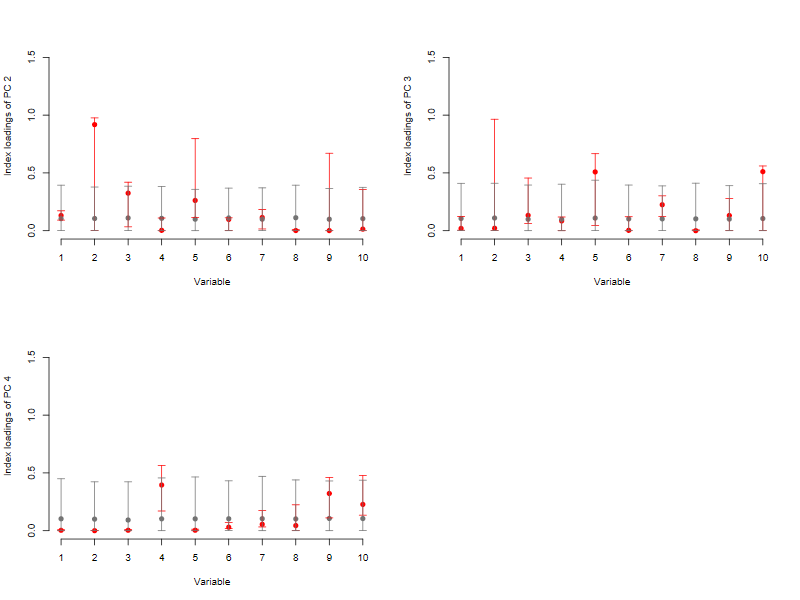

In [45]:
# Perform PCA
set.seed(42)
results <- PCAtest(num_data,
                  nperm = 1000,
                  nboot = 1000,
                  alpha = 0.05,
                  #scale = FALSE,
                  counter = FALSE,
                  plot = TRUE
                  )

In [46]:
loan_pca <- prcomp(loan_scaled, scale = FALSE, center = TRUE)

In [49]:
# Create the PCA recipe
pca_prep <- recipe(status~., data =data) |> 
  step_normalize(all_numeric_predictors()) |> 
  step_pca(all_numeric_predictors(), num_comp = 5) |> 
  prep()

In [50]:
pca_prep


── Recipe ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

── Inputs 
Number of variables by role
outcome:    1
predictor: 31

── Training information 
Training data contained 20000 data points and no incomplete rows.

── Operations 
• Centering and scaling for: loan_amount, rate_of_interest, interest_rate_spread, upfront_charges, term, property_value, income, ... | Trained
• PCA extraction with: loan_amount, rate_of_interest, interest_rate_spread, upfront_charges, term, property_value, income, ... | Trained

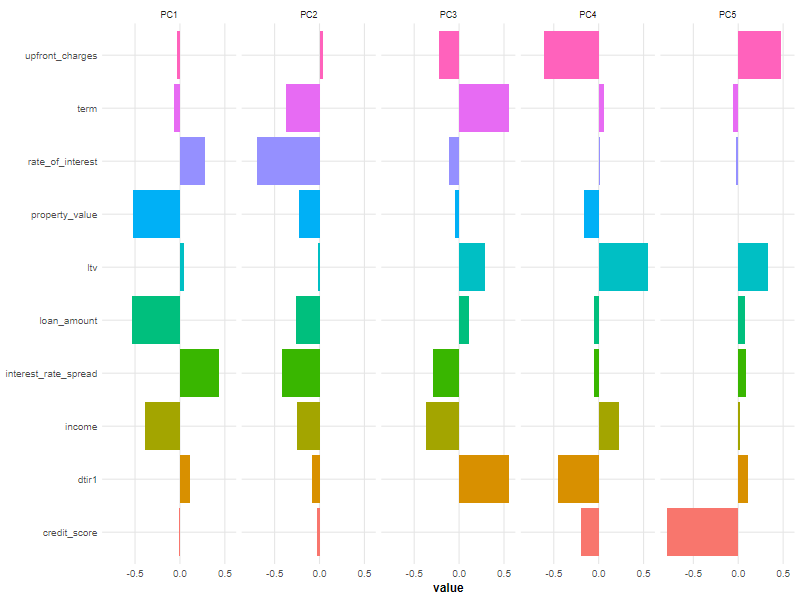

In [51]:
# Visualize the contribution of variables to the components

tidied_pca <- tidy(pca_prep, 2)
tidied_pca |> 
  filter(component %in% paste0("PC", 1:5)) |> 
  mutate(component = fct_inorder(component)) |> 
  ggplot(aes(value, terms, fill = terms)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~component, nrow = 1)+
  labs(y = NULL)

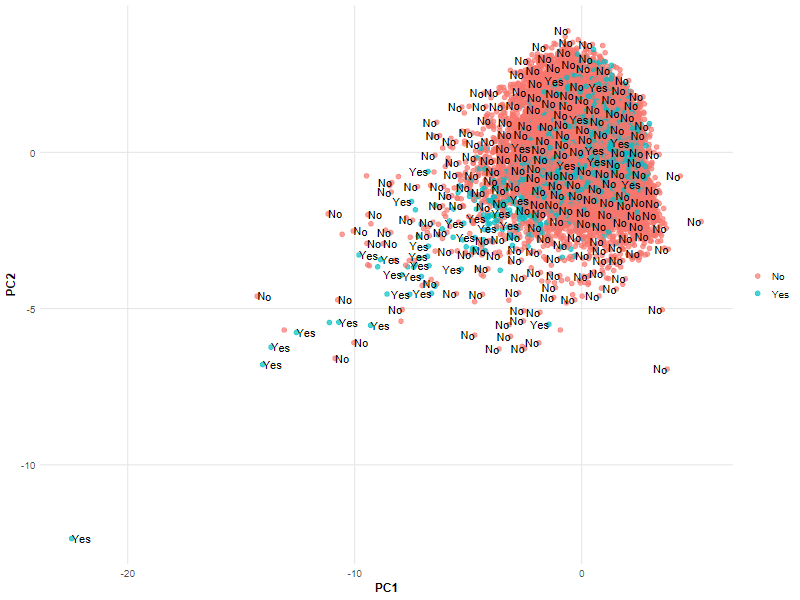

In [52]:
juice(pca_prep) %>%
  ggplot(aes(PC1, PC2, label = status)) +
  geom_point(aes(color = status), alpha = 0.7, size = 2) +
  geom_text(check_overlap = TRUE, hjust = "inward", family = "IBMPlexSans") +
  labs(color = NULL)

In [101]:
tidied_pca %>% 
  pivot_wider(names_from = component, values_from = value) %>% 
  select(-id) %>% 
  select(terms, PC1, PC2, PC3, PC4, PC5) -> standard_loadings

standard_loadings %>% 
  as.data.frame() -> standard_loadings

rownames(standard_loadings) <- standard_loadings$terms
standard_loadings <- standard_loadings %>% 
  select(-terms) 

sparse_loading_subset <- loadings_sparse[, 1:5]
colnames(sparse_loading_subset) <- paste0("SPC", 1:5)

# Combine both loadings
all_loadings <- cbind(standard_loadings, sparse_loading_subset)


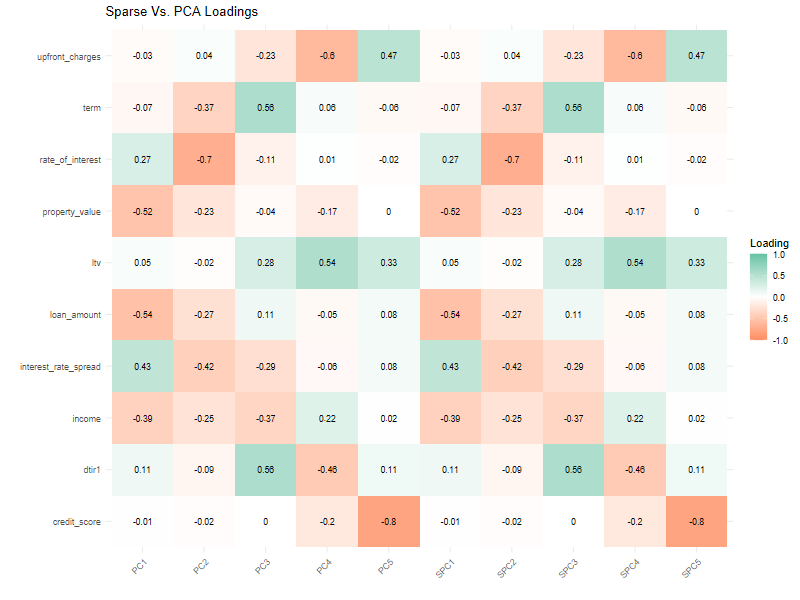

In [102]:
long_data <- all_loadings %>% 
  rownames_to_column(var = "terms") %>% 
  pivot_longer(cols = -terms, names_to = "Feature", values_to = "Loading")

ggplot(long_data, aes(Feature, terms, fill = Loading)) +
  geom_tile() +
  geom_text(aes(label = round(Loading, 2)), size = 3) +
  scale_fill_gradient2(low = "#fc8d62", mid = "white", high = "#66c2a5", 
  midpoint = 0, limits = c(-1, 1)) +
  labs(title = "Sparse Vs. PCA Loadings",
  x = "", y = "") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

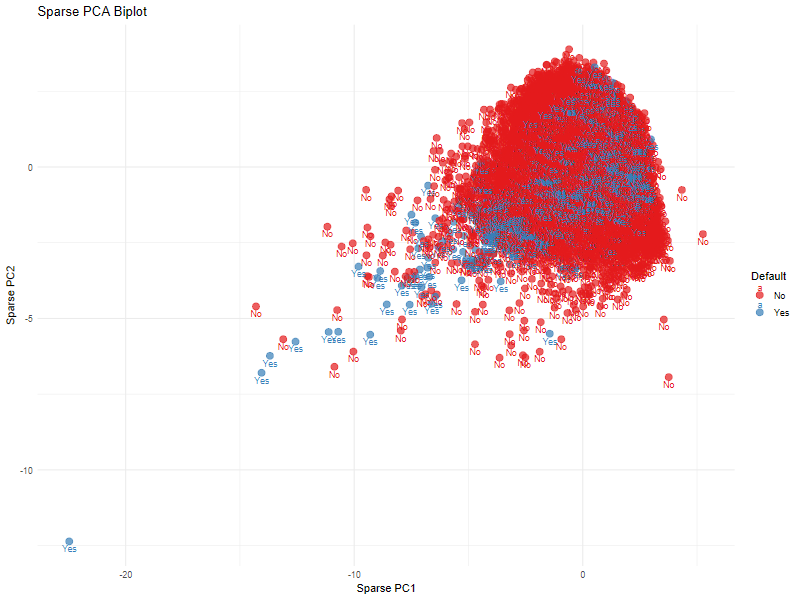

In [119]:
# Interactive Biplots for Sparse PCA
spca_scores <- loan_scaled %*% loadings_sparse[, 1:2]
biplot_data <- data.frame(
  PC1 = spca_scores[, 1],
  PC2 = spca_scores[, 2],
  Default = as.factor(data$status)
)

ggplot(biplot_data, aes(PC1, PC2, color = Default)) +
  geom_point(size = 3, alpha = 0.7) +
  geom_text(aes(label = Default), vjust = 1.5, size = 3) +
  scale_color_manual(values = c("#E41A1C", "#377EB8", "#4DAF4A")) +
  labs(title = "Sparse PCA Biplot",
       x = "Sparse PC1",
       y = "Sparse PC2") +
  theme_minimal()

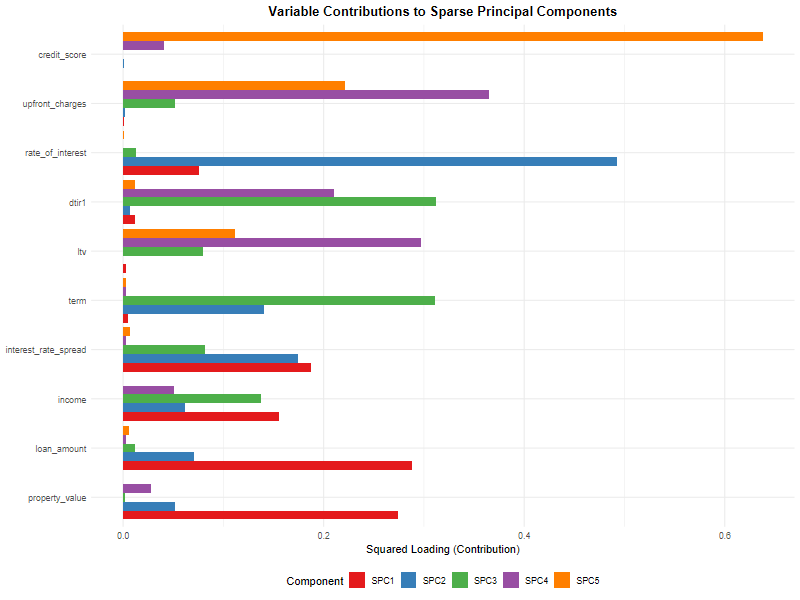

In [123]:
# Calculate variable contributions (squared loadings)
contrib_df <- as.data.frame(loadings_sparse^2)
colnames(contrib_df) <- paste0("SPC", 1:ncol(contrib_df))
contrib_df$Variable <- rownames(contrib_df)

contrib_long <- pivot_longer(contrib_df, 
                            cols = starts_with("SPC"), 
                            names_to = "Component", 
                            values_to = "Contribution")

# Sort by contribution within each component
contrib_long <- contrib_long %>%
  group_by(Component) %>%
  arrange(desc(Contribution)) %>%
  ungroup()

# Keep only non-zero contributions for clarity
contrib_long <- contrib_long %>% filter(Contribution > 0)

# Create a bar chart of variable contributions
ggplot(contrib_long, aes(x = reorder(Variable, Contribution), y = Contribution, fill = Component)) +
  geom_bar(stat = "identity", position = "dodge") +
  coord_flip() +
  scale_fill_brewer(palette = "Set1") +
  labs(title = "Variable Contributions to Sparse Principal Components",
       x = NULL,
       y = "Squared Loading (Contribution)") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),
        legend.position = "bottom")

# 6. Feature Importance and Selection

## 6.1 Statistical Tests for Feature Selection

In [116]:
if(target_var %in% names(data) && is.factor(data[[target_var]])) {
  # Initialize a dataframe to store feature importance results
  feature_importance <- data.frame(
    Feature = character(),
    p_value = numeric(),
    effect_size = numeric(),
    stringsAsFactors = FALSE
  )
  
  # Perform statistical tests for numeric features
  for(feat in numeric_cols) {
    # Perform Wilcoxon rank-sum test (non-parametric alternative to t-test)
    test_result <- wilcox.test(
      data[[feat]] ~ data[[target_var]], 
      exact = FALSE
    )
    
    # Calculate effect size (Cliff's delta)
    effect_size <- effsize::cliff.delta(
      data[[feat]] ~ data[[target_var]]
    )$estimate
    
    # Add to the dataframe
    feature_importance <- rbind(
      feature_importance,
      data.frame(
        Feature = feat,
        p_value = test_result$p.value,
        effect_size = abs(effect_size),
        stringsAsFactors = FALSE
      )
    )
  }
  
  # Perform chi-square tests for categorical features
  for(feat in categorical_cols) {
    if(feat != target_var) {
      # Contingency table
      cont_table <- table(data[[feat]], data[[target_var]])
      
      # Chi-square test
      test_result <- chisq.test(cont_table)
      
      # Calculate Cramer's V
      cramer_v <- sqrt(test_result$statistic / 
                     (sum(cont_table) * min(nrow(cont_table) - 1, ncol(cont_table) - 1)))
      
      # Add to the dataframe
      feature_importance <- rbind(
        feature_importance,
        data.frame(
          Feature = feat,
          p_value = test_result$p.value,
          effect_size = cramer_v,
          stringsAsFactors = FALSE
        )
      )
    }
  }
  # Adjust p-values for multiple testing
  feature_importance$adjusted_p_value <- p.adjust(feature_importance$p_value, method = "BH")
  
  # Sort by effect size
  feature_importance <- feature_importance %>%
    arrange(desc(effect_size))
  
  # Visualize feature importance
  ggplot(feature_importance, aes(x = reorder(Feature, effect_size), y = effect_size)) +
    geom_bar(stat = "identity", fill = "#3498db", alpha = 0.8) +
    geom_point(aes(color = adjusted_p_value < 0.05), size = 3) +
    scale_color_manual(values = c("FALSE" = "#e74c3c", "TRUE" = "#2ecc71"),
                       name = "Significant\n(adj. p < 0.05)") +
    labs(
      title = "Feature Importance Based on Statistical Tests",
      subtitle = "Effect size with significance indicators",
      x = "Feature",
      y = "Effect Size (absolute)"
    ) +
    coord_flip() +
    theme_minimal() +
    theme(
      plot.title = element_text(face = "bold", hjust = 0.5),
      plot.subtitle = element_text(hjust = 0.5)
    )
  
  # Display the top features
  feature_importance %>%
    slice_head(n = 10) %>%
    kable(caption = "Top 10 Features by Effect Size", digits = 4) %>%
    kable_styling()
}
  

Warning messages:
1: In chisq.test(cont_table) : Chi-squared approximation may be incorrect
2: In chisq.test(cont_table) : Chi-squared approximation may be incorrect
3: In chisq.test(cont_table) : Chi-squared approximation may be incorrect


: [1m[33mError[39m in `x$sizingPolicy`:[22m
[33m![39m $ operator is invalid for atomic vectors

## 6.2 Machine Learning-Based Feature Importance

In [36]:
# Create initial train/test split (70/30)
loan_split <- initial_split(data, prop = 0.7, strata = status)
loan_train <- training(loan_split)
loan_test <- testing(loan_split)

# Create cross-validation folds for tuning
loan_folds <- vfold_cv(loan_train, v = 5, strata = status)

# Display split information
split_info <- tribble(
  ~Dataset, ~Rows, ~`status (Yes)`, ~`status (No)`, ~`status Rate (%)`,
  "Original", nrow(data), 
  sum(data$status == "Yes"), 
  sum(data$status == "No"),
  mean(data$status == "Yes") * 100,
  
  "Training", nrow(loan_train), 
  sum(loan_train$status == "Yes"), 
  sum(loan_train$status == "No"),
  mean(loan_train$status == "Yes") * 100,
  
  "Testing", nrow(loan_test), 
  sum(loan_test$status == "Yes"), 
  sum(loan_test$status == "No"),
  mean(loan_test$status == "Yes") * 100
)

kable(split_info, caption = "Data Split Overview") 



Table: Data Split Overview

|Dataset  |  Rows| status (Yes)| status (No)| status Rate (%)|
|:--------|-----:|------------:|-----------:|---------------:|
|Original | 20000|         4929|       15071|        24.64500|
|Training | 13999|         3450|       10549|        24.64462|
|Testing  |  6001|         1479|        4522|        24.64589|

In [96]:
# Define preprocessing steps
loan_recipe <- recipe(status ~ ., data = loan_train) %>%
  # Convert date variables to useful features (if present)
  # step_date(loan_date, features = c("month", "year")) %>%
  
  # Handle missing values
  step_impute_knn(all_predictors(), neighbors = 5) %>%
  # Group Rare categories into other category
  step_other(all_nominal_predictors(), threshold = 0.2) %>% 
  # Treat new categories as new 
  step_novel(all_nominal_predictors()) %>% 
  
  # Create dummy variables for categorical predictors
  step_dummy(all_nominal_predictors()) %>%
  
  # Remove zero variance predictors
  step_nzv(all_predictors()) %>%
  
  # Remove highly correlated predictors
  step_corr(all_numeric_predictors(), threshold = 0.7) %>%
  
  # Normalize numeric predictors
  step_normalize(all_numeric_predictors()) %>%
  
  # Handle class imbalance using SMOTE
  themis::step_smote(status, over_ratio = 0.8)

# Print the recipe
loan_recipe


── Recipe ────────────────────────────────────────────────────────────────────────────────────────────────

── Inputs 
Number of variables by role
outcome:    1
predictor: 31

── Operations 
• K-nearest neighbor imputation for: all_predictors()
• Collapsing factor levels for: all_nominal_predictors()
• Novel factor level assignment for: all_nominal_predictors()
• Dummy variables from: all_nominal_predictors()
• Sparse, unbalanced variable filter on: all_predictors()
• Correlation filter on: all_numeric_predictors()
• Centering and scaling for: all_numeric_predictors()
• SMOTE based on: status

In [97]:
# Prepare the recipe
loan_prep <- prep(loan_recipe)

# View the processed training data
loan_train_processed <- juice(loan_prep)

# Summarize the processed data
loan_train_processed %>%
  glimpse()

# Count the number of predictors after preprocessing
num_predictors <- ncol(loan_train_processed) - 1
cat("Number of predictors after preprocessing:", num_predictors)

Rows: 18,988
Columns: 30
$ rate_of_interest                  <dbl> 0.8369705, 0.3584495, -2.5126767, 0.1191890, -2.0532965, -1.07…
$ interest_rate_spread              <dbl> 1.09556975, 1.13411908, -2.55267273, -0.03896968, -0.45214463,…
$ upfront_charges                   <dbl> 0.61197673, 0.69679519, 0.17789160, -0.02750974, 0.86444611, 0…
$ term                              <dbl> 0.4252797, 0.4252797, 0.4252797, -0.3903042, -2.6331599, -2.63…
$ property_value                    <dbl> -0.16419613, -0.81162918, -0.19362490, -0.45848388, 0.63038080…
$ income                            <dbl> -0.32368508, -0.54201891, -0.01583439, 0.40773323, 0.50598346,…
$ credit_score                      <dbl> 1.384659860, -1.429562367, 0.849439682, -1.351869115, 1.263803…
$ ltv                               <dbl> 0.06832856, 0.14809017, 0.20695321, -0.19140026, -0.55014809, …
$ dtir1                             <dbl> 0.6032648166, 0.8044436257, 0.1606714365, -0.8049868473, -1.50…
$ loan_limit_other   

In [99]:
rf_spec <- rand_forest(
  mtry = tune(),
  trees = 500,
  min_n = tune()
) %>%
  set_engine("ranger", importance = "impurity") %>%
  set_mode("classification")


xgb_spec <- boost_tree(
  trees = 500,
  tree_depth = tune(),
  min_n = tune(),
  loss_reduction = tune(),
  sample_size = tune(),
  mtry = tune(),
  learn_rate = tune()
) %>%
  set_engine("xgboost") %>%
  set_mode("classification")

log_reg_spec <- logistic_reg(
  penalty = tune(),
  mixture = tune()
) %>%
  set_engine("glmnet") %>%
  set_mode("classification")



In [100]:
library(finetune)
cl <- makePSOCKcluster(detectCores() - 1)
registerDoParallel(cl)
loan_workflow <- workflow_set(
  preproc = list(loan_recipe),
  models = list(
    randomforest = rf_spec,
    xgboost = xgb_spec,
    logistic_regression = log_reg_spec,
    neural_network = nnet_spec,
    decision_tree = dt_spec,
    bayesianAdditiveRT = bart_spec
  )
)

metrics <- metric_set(yardstick::accuracy, roc_auc, yardstick::sensitivity, yardstick::specificity, brier_class, yardstick::f_meas)
race_ctrl <- control_race(
  save_pred = TRUE,
  parallel_over = "everything",
  save_workflow = TRUE
)

race_results <- loan_workflow %>%
  workflow_map(
    seed = 42,
    fn = "tune_race_anova",
    resamples = loan_folds,
    grid = 10,
    metrics = metrics,
    control = race_ctrl
  )
stopCluster(cl)

i Creating pre-processing data to finalize unknown parameter: mtry
i Creating pre-processing data to finalize unknown parameter: mtry


In [101]:
race_results <- race_results %>% 
  mutate(wflow_id = gsub("recipe_", "", wflow_id))
race_results

# A workflow set/tibble: 6 × 4
  wflow_id            info             option    result   
  <chr>               <list>           <list>    <list>   
1 randomforest        <tibble [1 × 4]> <opts[4]> <race[+]>
2 xgboost             <tibble [1 × 4]> <opts[4]> <race[+]>
3 logistic_regression <tibble [1 × 4]> <opts[4]> <race[+]>
4 neural_network      <tibble [1 × 4]> <opts[4]> <race[+]>
5 decision_tree       <tibble [1 × 4]> <opts[4]> <race[+]>
6 bayesianAdditiveRT  <tibble [1 × 4]> <opts[4]> <race[+]>

In [102]:
race_results %>% 
  rank_results() %>% 
  filter(.metric == "f_meas") %>% 
  select(model, .config, f1_score = mean, rank)

# A tibble: 12 × 4
   model         .config               f1_score  rank
   <chr>         <chr>                    <dbl> <int>
 1 boost_tree    Preprocessor1_Model02    0.988     1
 2 boost_tree    Preprocessor1_Model03    0.987     2
 3 rand_forest   Preprocessor1_Model08    0.981     3
 4 rand_forest   Preprocessor1_Model01    0.979     4
 5 rand_forest   Preprocessor1_Model05    0.979     5
 6 rand_forest   Preprocessor1_Model10    0.979     6
 7 bart          Preprocessor1_Model03    0.955     7
 8 bart          Preprocessor1_Model09    0.952     8
 9 decision_tree Preprocessor1_Model10    0.945     9
10 decision_tree Preprocessor1_Model02    0.942    10
11 mlp           Preprocessor1_Model02    0.914    11
12 logistic_reg  Preprocessor1_Model06    0.912    12

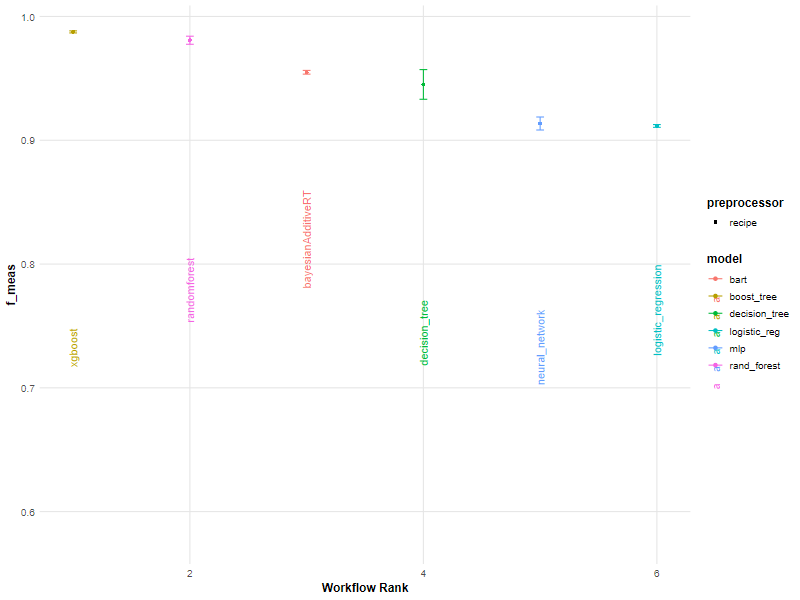

In [103]:
autoplot(race_results,
  rank_metric = "f_meas",
  metric = "f_meas",
  select_best = TRUE) +
  geom_text(aes(y = mean - 1/3, label = wflow_id), angle = 90, hjust = -2) 

In [104]:
# Extract all metrics and predictions
all_metrics <- collect_metrics(race_results)
all_predictions <- collect_predictions(race_results)
# 1. Overall Performance Comparison
overall_comparison <- race_results %>%
  collect_metrics() %>%
  group_by(wflow_id, .metric) %>%
  summarise(
    mean_perf = mean(mean),
    sd_perf = sd(mean),
    .groups = "drop"
  ) %>%
  arrange(wflow_id, mean_perf)

overall_comparison

Warning messages:
1: In UseMethod("mean") : closing unused connection 6 (<-Olande:11471)
2: In UseMethod("mean") : closing unused connection 5 (<-Olande:11471)
3: In UseMethod("mean") : closing unused connection 4 (<-Olande:11471)


# A tibble: 36 × 4
   wflow_id           .metric     mean_perf sd_perf
   <chr>              <chr>           <dbl>   <dbl>
 1 bayesianAdditiveRT brier_class    0.0564 0.00125
 2 bayesianAdditiveRT specificity    0.788  0.00594
 3 bayesianAdditiveRT accuracy       0.929  0.00268
 4 bayesianAdditiveRT f_meas         0.954  0.00173
 5 bayesianAdditiveRT roc_auc        0.961  0.00359
 6 bayesianAdditiveRT sensitivity    0.975  0.00161
 7 decision_tree      brier_class    0.0657 0.00239
 8 decision_tree      specificity    0.842  0.00799
 9 decision_tree      accuracy       0.915  0.00389
10 decision_tree      sensitivity    0.939  0.00255
# ℹ 26 more rows
# ℹ Use `print(n = ...)` to see more rows

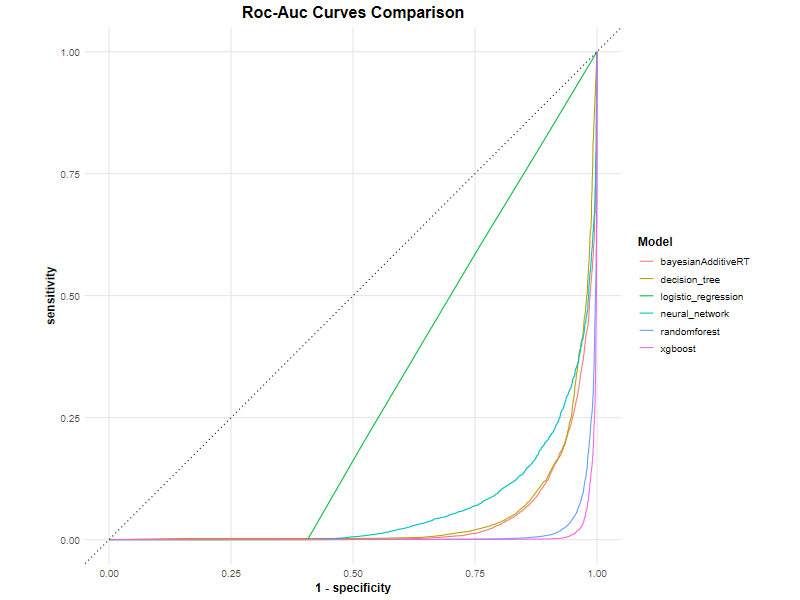

In [105]:
# 2. ROC Curves Comparison
roc_curves <- all_predictions %>%
  group_by(wflow_id) %>%
  roc_curve(truth = status, .pred_Yes) %>%
  autoplot() +
  theme_custom() +
  labs(
      title = "Roc-Auc Curves Comparison",
      color = "Model"
    )

roc_curves

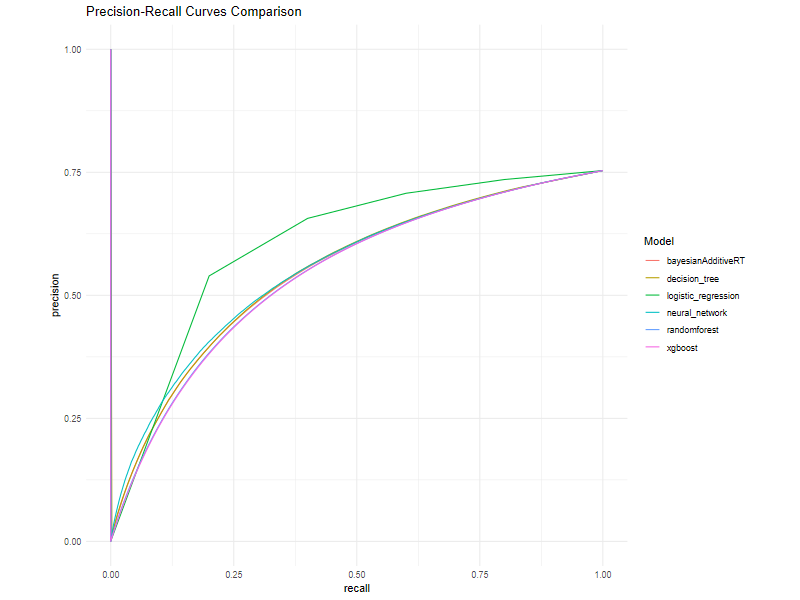

In [106]:
# 3. Precision-Recall Curves
pr_curves <- all_predictions %>%
  group_by(wflow_id) %>%
  pr_curve(truth = status, .pred_Yes) %>%
  autoplot() +
  theme_minimal() +
  labs(
    title = "Precision-Recall Curves Comparison",
    color = "Model"
  )
pr_curves

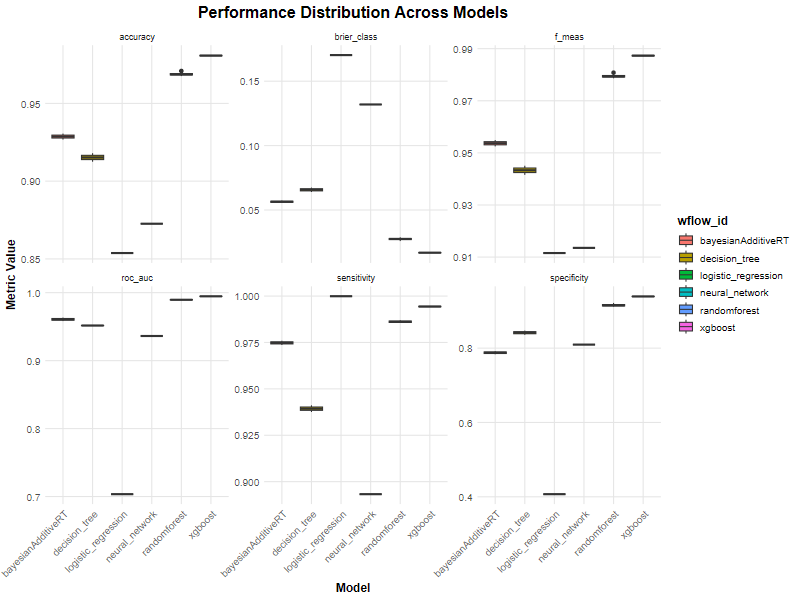

In [107]:
# 4. Performance Distribution Boxplots
metric_distributions <- all_metrics %>%
  ggplot(aes(x = wflow_id, y = mean, fill = wflow_id)) +
  geom_boxplot() +
  facet_wrap(~.metric, scales = "free_y") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(
    title = "Performance Distribution Across Models",
    x = "Model",
    y = "Metric Value"
  )

metric_distributions

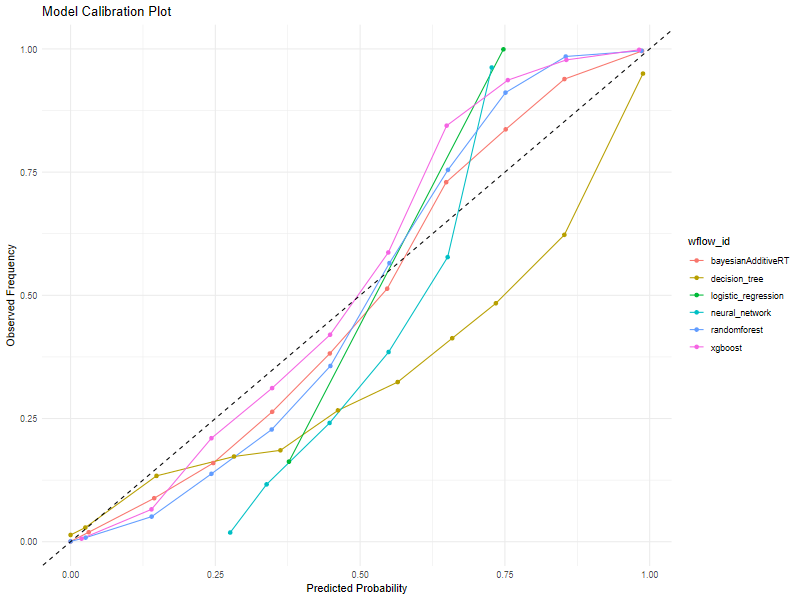

In [108]:
# 5. Model Calibration
calibration_plots <- all_predictions %>%
  group_by(wflow_id) %>%
  mutate(pred_bin = cut(.pred_Yes, breaks = seq(0, 1, by = 0.1))) %>%
  group_by(wflow_id, pred_bin) %>%
  summarise(
    observed_prob = mean(status == "Yes"),
    predicted_prob = mean(.pred_Yes),
    .groups = "drop"
  ) %>%
  ggplot(aes(x = predicted_prob, y = observed_prob, color = wflow_id)) +
  geom_line() +
  geom_point() +
  geom_abline(linetype = "dashed") +  # Ideal calibration line
  theme_minimal() +
  labs(title = "Model Calibration Plot", x = "Predicted Probability", y = "Observed Frequency")

calibration_plots

In [109]:
# 6. Model Rankings
model_rankings <- all_metrics %>%
  group_by(.metric, wflow_id) %>%
  summarise(mean = mean(mean), .groups = "drop") %>%
  mutate(rank = rank(-mean)) %>%
  pivot_wider(names_from = .metric, values_from = c(mean, rank)) %>%
  arrange(rank_roc_auc) %>%
  kable(caption = "Average model rankings based on selected metrics")

print(model_rankings)




Table: Average model rankings based on selected metrics

|wflow_id            | mean_accuracy| mean_brier_class| mean_f_meas| mean_roc_auc| mean_sensitivity| mean_specificity| rank_accuracy| rank_brier_class| rank_f_meas| rank_roc_auc| rank_sensitivity| rank_specificity|
|:-------------------|-------------:|----------------:|-----------:|------------:|----------------:|----------------:|-------------:|----------------:|-----------:|------------:|----------------:|----------------:|
|xgboost             |     0.9807487|        0.0168503|   0.9873177|    0.9946599|        0.9943596|        0.9391304|             7|               36|           5|            2|                3|               16|
|randomforest        |     0.9689087|        0.0274102|   0.9795092|    0.9895935|        0.9862309|        0.9159420|            10|               35|           8|            4|                6|               19|
|bayesianAdditiveRT  |     0.9286730|        0.0563862|   0.9536967|    0.9607763

In [110]:
# Ensure `wflow_id` is a factor (categorical variable)
all_metrics <- all_metrics %>%
  mutate(wflow_id = as.factor(wflow_id))

# Ensure each fold is treated as a blocking factor
# Create `id` to represent the blocking factor (folds)
all_metrics <- all_metrics %>%
  mutate(id = rep(1:floor(n()/length(unique(wflow_id))),
                  each = length(unique(wflow_id)), length.out = n()))

# Filter only rows where `.metric` is "f1 score"
roc_metrics <- all_metrics %>%
  filter(.metric == "f_meas")

# Ensure `mean` (roc_auc values) is numeric
roc_metrics <- roc_metrics %>%
  mutate(mean = as.numeric(mean))

# Check for missing values
missing_data <- roc_metrics %>%
  group_by(id, wflow_id) %>%
  summarise(n = n(), .groups = "drop") %>%
  pivot_wider(names_from = wflow_id, values_from = n)


# Create properly formatted data for Friedman test
friedman_data <- roc_metrics %>%
  select(id, wflow_id, mean) %>%  
  pivot_wider(
    names_from = wflow_id,
    values_from = mean
  )


# Perform Friedman test
friedman_result <- friedman.test(as.matrix(friedman_data[,-1]))

print("\nFriedman test results:")
print(friedman_result)

# If Friedman test is significant, perform post-hoc analysis
if(friedman_result$p.value < 0.05) {
  # Perform pairwise Wilcoxon signed rank tests with p-value adjustment
  posthoc <- all_metrics %>%
    wilcox_test(
      mean ~ wflow_id,
      paired = TRUE,
      p.adjust.method = "bonferroni"
    )
  
  print("\nPost-hoc analysis results:")
  print(posthoc)
}


[1] "\nFriedman test results:"

	Friedman rank sum test

data:  as.matrix(friedman_data[, -1])
Friedman chi-squared = NaN, df = 5, p-value = NA



: [1m[33mError[39m in `if (friedman_result$p.value < 0.05) ...`:[22m
[33m![39m missing value where TRUE/FALSE needed

Warning message:
Removed 8 rows containing missing values or values outside the scale range (`geom_col()`). 


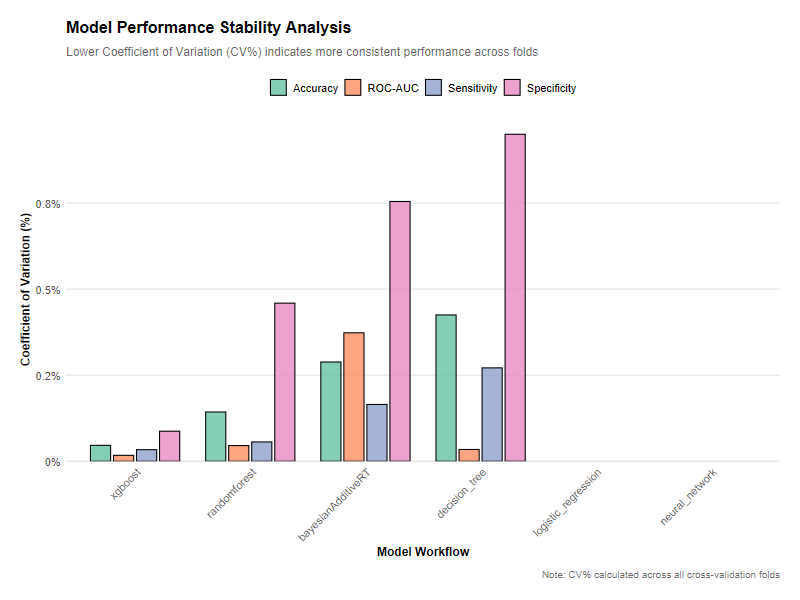

In [111]:
# Stability Plot Analysis
stability_plot <- all_metrics %>%
  # Filter for relevant metrics
  filter(.metric %in% c("accuracy", "roc_auc", "sensitivity", "specificity")) %>%
  # Calculate stability metrics
  group_by(wflow_id, .metric) %>%
  summarise(
    mean_perf = mean(mean),
    sd_perf = sd(mean),
    cv = sd_perf / mean_perf * 100,
    .groups = "drop"
  ) %>%
  # Create plot
  ggplot(aes(x = reorder(wflow_id, cv), y = cv, fill = .metric)) +
  geom_col(position = position_dodge(width = 0.8),
           width = 0.7,
           color = "black",
           alpha = 0.8) +
  # Custom color palette
  scale_fill_brewer(palette = "Set2",
                    labels = c("Accuracy", "ROC-AUC", "Sensitivity", "Specificity")) +
  # Formatting
  scale_y_continuous(
    #limits = c(0, max(cv) * 1.1),
    labels = function(x) paste0(round(x, 1), "%"),
    expand = expansion(mult = c(0, 0.05))
  ) +
  # Clean theme
  theme_minimal(base_size = 12, base_family = "Arial") +
  theme(
    plot.title = element_text(size = 16, face = "bold", margin = margin(b = 10)),
    plot.subtitle = element_text(size = 12, color = "grey40", margin = margin(b = 20)),
    plot.caption = element_text(size = 10, color = "grey40", margin = margin(t = 10)),
    axis.title = element_text(size = 12, face = "bold"),
    axis.text = element_text(size = 11),
    axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1),
    legend.position = "top",
    legend.title = element_blank(),
    legend.text = element_text(size = 11),
    legend.margin = margin(b = 10),
    panel.grid.major.x = element_blank(),
    panel.grid.minor = element_blank(),
    panel.grid.major.y = element_line(color = "grey90"),
    plot.margin = margin(20, 20, 20, 20)
  ) +
  # Labels
  labs(
    title = "Model Performance Stability Analysis",
    subtitle = "Lower Coefficient of Variation (CV%) indicates more consistent performance across folds",
    x = "Model Workflow",
    y = "Coefficient of Variation (%)",
    caption = "Note: CV% calculated across all cross-validation folds"
  )

# Display the plot
stability_plot

In [112]:
performance_table <- overall_comparison %>%
  arrange(desc(mean_perf)) %>% # Sort by performance
  kable(format = "html", digits = 3, caption = "Model Performance Summary") %>%
  kable_styling(full_width = FALSE, bootstrap_options = c("striped", "hover", "condensed")) %>%
  row_spec(0, bold = TRUE) %>%  # Make header bold
  column_spec(2:3, width = "15em") %>% # Adjust column width
  pack_rows("Top Performing Models", 1, 3, label_row_css = "font-weight: bold; background-color: #e6f3ff;") # Highlight top 3

In [116]:
best_results <- race_results %>% 
  extract_workflow_set_result("xgboost") %>% 
  select_best(metric = "f_meas")

print(best_results)

Warning message:
Metric "accuracy" was used to evaluate model candidates in the race but "f_meas" has been chosen to rank the candidates. These results may not agree
with the race. 


# A tibble: 1 × 7
   mtry min_n tree_depth learn_rate loss_reduction sample_size .config              
  <int> <int>      <int>      <dbl>          <dbl>       <dbl> <chr>                
1    24    24          4      0.116       0.000866       0.780 Preprocessor1_Model02


In [121]:
race_results %>% 
  extract_workflow("xgboost") %>% 
  finalize_workflow(best_results) %>% 
  last_fit(loan_split) -> final_fit

In [124]:
collect_metrics(final_fit)

# A tibble: 3 × 4
  .metric     .estimator .estimate .config             
  <chr>       <chr>          <dbl> <chr>               
1 accuracy    binary        0.985  Preprocessor1_Model1
2 roc_auc     binary        0.995  Preprocessor1_Model1
3 brier_class binary        0.0142 Preprocessor1_Model1

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
[[1]]
# A tibble: 3 × 4
  .metric     .estimator .estimate .config             
  <chr>       <chr>          <dbl> <chr>               
1 accuracy    binary        0.985  Preprocessor1_Model1
2 roc_auc     binary        0.995  Preprocessor1_Model1
3 brier_class binary        0.0142 Preprocessor1_Model1

[[2]]



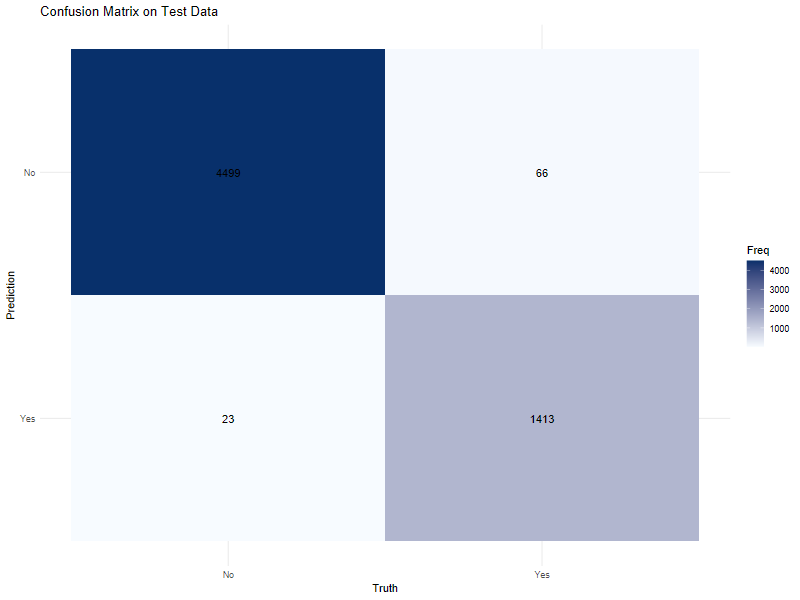

In [123]:
final_fit %>% 
  collect_predictions() %>% 
  conf_mat(truth = status, 
      estimate = .pred_class) -> conf_mat

confusion_matrix <- conf_mat %>%
  autoplot(type = "heatmap") +
  labs(title = "Confusion Matrix on Test Data") +
  scale_fill_gradient(low = "#f7fbff", high = "#08306b") +
  theme_minimal()

final_metrics <- collect_metrics(final_fit)
print(list(final_metrics, confusion_matrix))



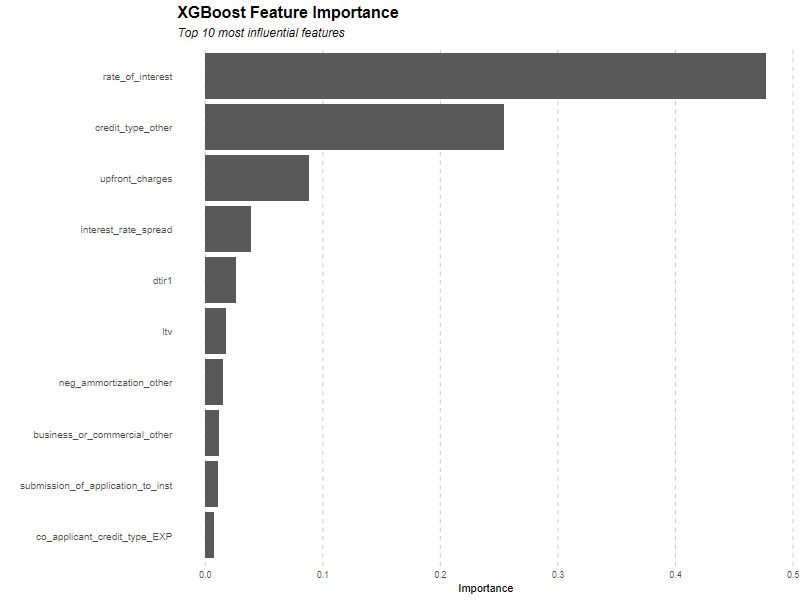

In [138]:
vip(extract_fit_parsnip(final_fit), num_features = 10, geom = "col") +
  theme_minimal() +
  labs(title = "XGBoost Feature Importance",
       subtitle = "Top 10 most influential features") +
  theme(plot.title = element_text(face = "bold", size = 16),
        plot.subtitle = element_text(face = "italic", size = 12),
        axis.text.y = element_text(size = 10),
        panel.grid.major.x = element_line(linetype = "dashed", color = "gray80"),
        panel.grid.minor = element_blank(),
        panel.grid.major.y = element_blank()) +
  scale_fill_viridis_c()

In [141]:
library(shapviz)
#library(pdp)
#library(iml)
library(lime)

: [1m[33mError[39m in `library()`:[22m
[33m![39m there is no package called ‘lime’